### Pola spasial tingkat kesejahteraan Kecamatan Krejengan
<p style="text-align: justify;">Notebook ini dikhususkan untuk pemetaan pola spasial tingkat kesejahteraan di wilayah Kecamatan Krejengan. 

**Memuat Library Python**

In [18]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import os

**Membuat fungsi Batas Plot**
<br>Fungsi ini membantu mengatur batas plot dengan menambahkan sedikit padding di sekitar area geografis yang menjadi fokus.<br>

In [19]:
def set_plot_bounds(ax, gdf, padding=0.1):
    bounds = gdf.total_bounds
    width = bounds[2] - bounds[0]
    height = bounds[3] - bounds[1]
    ax.set_xlim(bounds[0] - width * padding, bounds[2] + width * padding)
    ax.set_ylim(bounds[1] - height * padding, bounds[3] + height * padding)

**Memuat dan Menyiapkan Data**
<br>Di sini, kita melakukan dua hal utama:

1. Memuat data RWI dari file CSV dan mengubahnya menjadi GeoDataFrame dengan geometri titik.
2. Memuat data batas administratif Kecamatan dan Desa dari file GeoJSON.

In [35]:
# Memuat data RWI
df = pd.read_csv(r'E:\Project\GH\spasialRWI\data\idn_relative_wealth_index.csv')
gdf_points = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326"
)

# Memuat data batas administratif Kecamatan
gdf_krejengan = gpd.read_file(r'E:\Project\GH\spasialRWI\data\geojson\kecamatan\35.13.15.geojson')

# Memuat data Desa
folder_desa = r'E:\Project\GH\batas\geojson\hasil\KrejenganDesa'
gdf_desa = gpd.GeoDataFrame()

for filename in os.listdir(folder_desa):
    if filename.endswith('.geojson'):
        file_path = os.path.join(folder_desa, filename)
        gdf_temp = gpd.read_file(file_path)
        gdf_desa = pd.concat([gdf_desa, gdf_temp], ignore_index=True)
print(gdf_desa.columns)
print(f"Jumlah Desa yang dimuat: {len(gdf_desa)}")

Index(['code', 'name', 'geometry'], dtype='object')
Jumlah Desa yang dimuat: 17


**Memproyeksikan Ulang Data**
<br>Kita memproyeksikan ulang dataset ke EPSG:3857 (proyeksi Web Mercator). <br>
Ini penting untuk operasi spasial dan visualisasi yang akurat.

In [36]:
# Memproyeksikan ulang data ke sistem koordinat yang sesuai (Web Mercator)
gdf_points = gdf_points.to_crs(epsg=3857)
gdf_krejengan = gdf_krejengan.to_crs(epsg=3857)
gdf_desa = gdf_desa.to_crs(epsg=3857)

print(f"CRS data points: {gdf_points.crs}")
print(f"CRS data Krejengan: {gdf_krejengan.crs}")
print(f"CRS data Desa di Krejengan: {gdf_desa.crs}")

CRS data points: EPSG:3857
CRS data Krejengan: EPSG:3857
CRS data Desa di Krejengan: EPSG:3857


**Penggabungan Spasial**
<br>Operasi ini melakukan penggabungan spasial untuk menyaring hanya titik-titik RWI yang berada dalam batas Probolinggo.<br>

In [37]:
# Penggabungan spasial untuk mendapatkan nilai RWI pada peta Probolinggo
gdf_points_krejengan = gpd.sjoin(gdf_points, gdf_krejengan, how="inner", predicate="within")

**Membuat Peta**
<br>Bagian ini membuat peta akhir:

1. Menyiapkan plot dengan ukuran yang ditentukan.
2. MMenekankan batas administratif.
3. Memplot titik-titik RWI, diwarnai berdasarkan nilai RWI-nya.
4. Mengatur batas plot menggunakan fungsi pembantu kita.
5. Menambahkan judul dan label.
6. Menambahkan peta dasar OpenStreetMap untuk konteks.

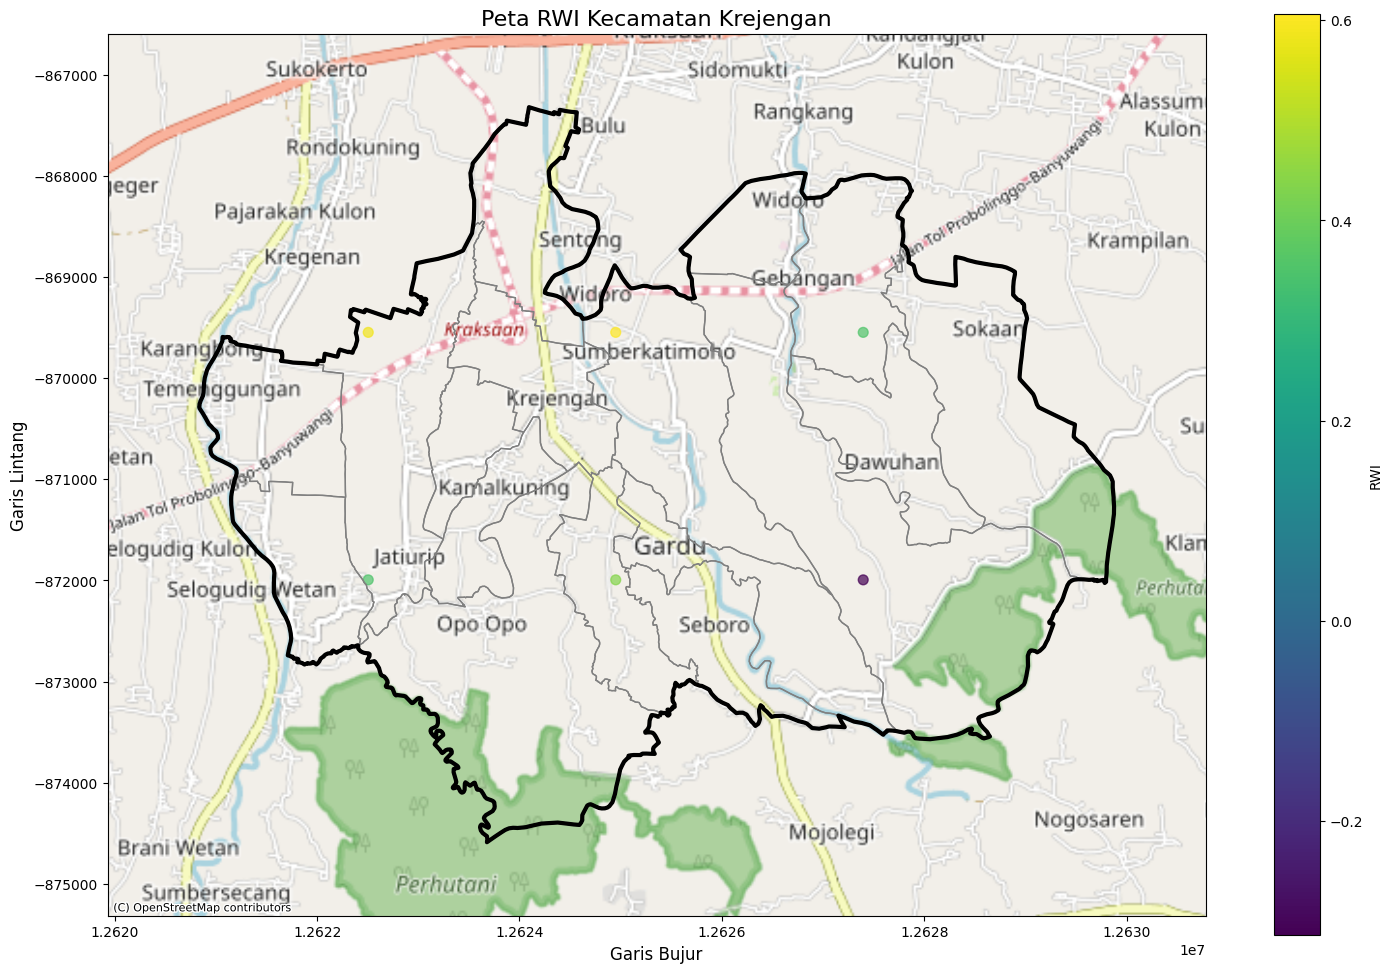

In [39]:
# Plot peta RWI Probolinggo dengan batas kecamatan
fig, ax = plt.subplots(figsize=(15, 10))

# Plot batas Kecamatan
gdf_krejengan.plot(ax=ax, color='none', edgecolor='black', linewidth=2)

# Plot batas Desa
gdf_desa.boundary.plot(ax=ax, color='grey', linewidth=1)

# Plot titik-titik RWI
scatter = gdf_points_krejengan.plot(ax=ax, column='rwi', cmap='viridis', 
                                         legend=True, legend_kwds={'label': 'RWI'},
                                         markersize=50, alpha=0.7)

# Mengatur batas plot
set_plot_bounds(ax, gdf_krejengan, padding=0.1)

# Menambahkan judul dan label
plt.title('Peta RWI Kecamatan Krejengan', fontsize=16)
plt.xlabel('Garis Bujur', fontsize=12)
plt.ylabel('Garis Lintang', fontsize=12)

# Menambahkan peta dasar
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=13)

# Menekankan batas Probolinggo
gdf_krejengan.boundary.plot(ax=ax, color='black', linewidth=3)

plt.tight_layout()
plt.show()

Statistik RWI Per Desa Wilayah Krejengan

In [41]:
# Menghitung statistik Tingkat Kesejahteraan per Desa
gdf_points_krejengan = gdf_points_krejengan.rename(columns={'index_right': 'index_right_old'})
gdf_desa = gdf_desa.rename(columns={'name': 'WADMDS'})

gdf_rwi_krejengan = gpd.sjoin(gdf_points_krejengan, gdf_desa, how="inner")
rwi_stats = gdf_rwi_krejengan.groupby('WADMDS')['rwi'].agg(['mean', 'median', 'std']).reset_index()
rwi_stats = rwi_stats.sort_values('mean', ascending=False)

print("Statistik Tingkat Kesejahteraan per Desa:")
print(rwi_stats)

Statistik Tingkat Kesejahteraan per Desa:
           WADMDS    mean  median       std
4  Sumberkatimoho  0.6060  0.6060       NaN
1        Jatiurip  0.4665  0.4665  0.167584
3           Rawan  0.4370  0.4370       NaN
0        Gebangan  0.3530  0.3530       NaN
2     Kedungcaluk -0.3140 -0.3140       NaN


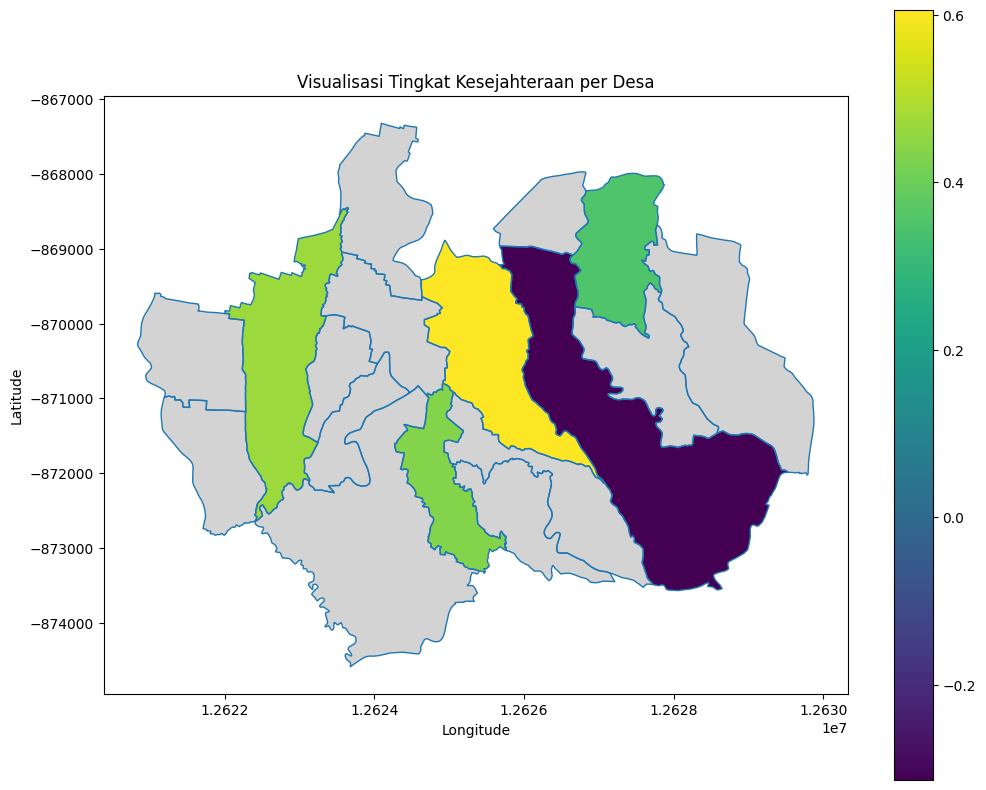

In [43]:
# Gabungkan GeoDataFrame dengan DataFrame RWI
gdf_desa_visual = gdf_desa.merge(rwi_stats, on='WADMDS', how='left')

# Buat choropleth map
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
gdf_desa_visual.boundary.plot(ax=ax, linewidth=1)
gdf_desa_visual.plot(column='mean', ax=ax, legend=True,
                   cmap='viridis', 
                   missing_kwds={"color": "lightgrey", "label": "Missing values"})

# Tambahkan judul
plt.title('Visualisasi Tingkat Kesejahteraan per Desa')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Tampilkan peta
plt.show()